In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.color_palette()
from sklearn.metrics.pairwise import euclidean_distances as euc_dist
from eval_ds import *
from embed_evals import get_knn_score, get_triplet_acc, get_val2train_triplet_acc, syn_evals
%config InlineBackend.figure_format='retina'

/data/anaconda3/envs/hanliu-tutorial/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from torchvision.datasets import ImageFolder
train_ds = ImageFolder('../datasets/bm/train')
valid_ds = ImageFolder('../datasets/bm/valid')
test_ds = ImageFolder('../datasets/bm/test')
y_train = np.array([y for _, y in train_ds])
y_valid = np.array([y for _, y in valid_ds])
y_test = np.array([y for _, y in test_ds])
ytvs = y_train, y_valid, y_test

In [4]:
p2i_train = pickle.load(open('../datasets/img2idx/bm_train.pkl', 'rb'))
p2i_valid = pickle.load(open('../datasets/img2idx/bm_valid.pkl', 'rb'))
p2i_test = pickle.load(open('../datasets/img2idx/bm_test.pkl', 'rb'))
i2p_train = {v:k for k, v in p2i_train.items()}
i2p_valid = {v:k for k, v in p2i_valid.items()}
i2p_test = {v:k for k, v in p2i_test.items()}

In [5]:
df = pd.read_csv('../datasets/bm_prolific_triplets/ab1-3.results.csv', index_col=0).reset_index(drop=True)
df['ttt'] = df['trips_train'].apply(eval).apply(lambda row: np.array([list(map(lambda i: p2i_train[i], trip)) for trip in row]))
df['vtt'] = df['trips_validtt'].apply(eval).apply(lambda row: np.array([[p2i_valid[trip[0]], p2i_train[trip[1]], p2i_train[trip[2]]] for trip in row]))
df['stt'] = df['trips_testtt'].apply(eval).apply(lambda row: np.array([[p2i_test[trip[0]], p2i_train[trip[1]], p2i_train[trip[2]]] for trip in row]))

In [6]:
def get_apn(trips, ytvs, fold):
    yt, yv, ys = ytvs
    ya = yv if fold == 'validtt' or fold == 'vtt' else ys if fold == 'testtt' or fold == 'stt' else yt
    yp, yn = yt, yt
    a = np.take(ya, trips[:,0])
    p = np.take(yp, trips[:,1])
    n = np.take(yn, trips[:,2])
    return a, p, n

def get_apn_acc(a, p, n):
    apn = (a == p) & (a == n)
    ap_n = (a == p) & (a != n)
    an_p = (a == n) & (a != p)
    a_pn = (a != p) & (p == n)
    # return ap_n.sum() / (ap_n | an_p).sum(), (ap_n | an_p).sum()
    return ap_n.sum() / (ap_n | an_p).sum()

def get_clf_apn(a, p, n):
    apn = (a == p) & (a == n)
    ap_n = (a == p) & (a != n)
    an_p = (a == n) & (a != p)
    a_pn = (a != p) & (p == n)
    return ap_n, (ap_n | an_p)

0.6961666193820799

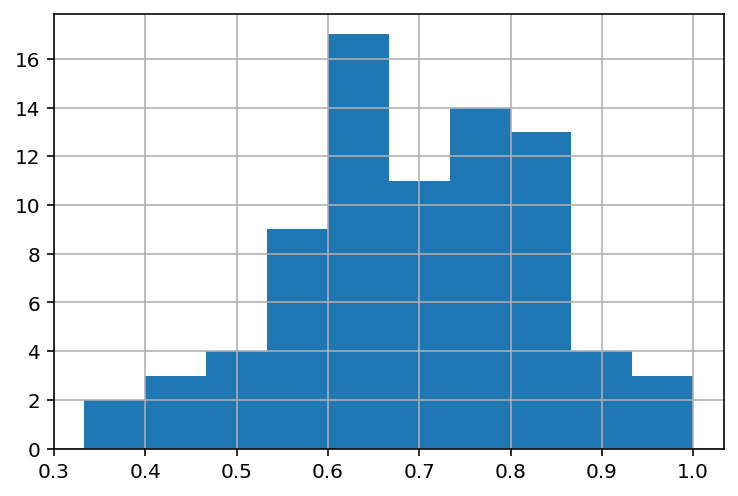

In [7]:
df['tapn'] = df['ttt'].apply(lambda x: get_apn(x, ytvs, fold='ttt'))
df['tapn'].apply(lambda r: get_apn_acc(*r)).hist()
df['tapn'].apply(lambda r: get_apn_acc(*r)).mean()

In [8]:
from itertools import chain
ttt = np.vstack(list(chain(df['ttt'])))
vtt = np.vstack(list(chain(df['vtt'])))
stt = np.vstack(list(chain(df['stt'])))

In [9]:
def load_all_embs(path, models, dim, arch=None, seeds=None):
    emb, folds = {}, ['train', 'valid', 'test']
    for model in models:
        if model not in emb: emb[model] = {}
        for fold in folds:
            if fold not in emb[model]: emb[model][fold] = {}
            model_path = '/'.join([path, model, arch]) if arch else '/'.join([path, model])
            if seeds:
                for seed in seeds:
                    emb[model][fold][seed] = pickle.load(
                        open(f'{model_path}_{fold}_emb{dim}_s{seed}.pkl', 'rb'))
            else:
                emb[model][fold] = pickle.load(
                    open(f'{model_path}_{fold}_emb{dim}.pkl', 'rb'))
    return emb

def get_dst_from_embs():
    pass

In [10]:
path = '../embeds/bm/prolific'
syns = load_all_embs(path, ['RESN', 'TN'], 512)

In [27]:
path = '../embeds/bm/prolific/bm_prolific_d50_e100'
models = [f'MTL{l}' for l in [0, 0.2, 0.5, 0.8, 1]]
seeds = list(range(6))
embs = load_all_embs(path, models, 50, 'MTL_han', seeds)

In [24]:
z_train, z_test = embs['MTL0']['train'][0], embs['MTL0']['test'][0]
s_train, s_test = syns['TN']['train'], syns['TN']['test']
evals = syn_evals(z_train, y_train, z_test, y_test, s_train, s_test, None, None)

In [48]:
syns['lpips.alex'] = pickle.load(open('../embeds/lpips/bm/lpips.alex.dstt.pkl', 'rb'))
syns['lpips.vgg'] = pickle.load(open('../embeds/lpips/bm/lpips.vgg.dstt.pkl', 'rb'))

In [2]:
embeds

NameError: name 'embeds' is not defined

In [49]:
results = pd.DataFrame(columns=['model', 'agent', 'seed'] + list(evals.keys()))
i = 0
for syn in syns:
    if 'lpips' not in syn:
        s_train, s_test = syns[syn]['train'], syns[syn]['test']
        syn_dist = euc_dist(s_test, s_train)
    else:
        syn_dist = syns[syn]
    for model in models:
        for seed in seeds:
            z_train, z_test = embs[model]['train'][seed], embs[model]['test'][seed]
            evals = syn_evals(z_train, y_train, z_test, y_test, None, None, None, None, dist=syn_dist)
            results.loc[i] = [model, syn, seed] + list(evals.values())
            i += 1

In [176]:
def get_ci(samples, confidence=0.95):
    from scipy import stats
    return 2 * stats.sem(samples) * stats.t.ppf((1 + confidence) / 2., len(samples)-1)
ds_columns = ['NINO_ds_acc', 'NIFO_ds_acc', 'rNINO_ds_acc']
df_mean = results.groupby(['agent', 'model']).agg({'NINO_ds_acc': 'mean', 'NIFO_ds_acc': 'mean', 'rNINO_ds_acc': 'mean'})
df_sems = results.groupby(['agent', 'model']).agg({'NINO_ds_acc': get_ci, 'NIFO_ds_acc': get_ci, 'rNINO_ds_acc': get_ci})
df_mean = df_mean.reset_index()
df_sems = df_sems.reset_index()

In [177]:
df_mean[df_mean['agent'] == 'lpips.alex']

,agent,model,NINO_ds_acc,NIFO_ds_acc,rNINO_ds_acc
10,lpips.alex,MTL0,0.620833,0.875000,0.666667
11,lpips.alex,MTL0.2,0.604167,0.900000,0.666667
12,lpips.alex,MTL0.5,0.570833,0.887500,0.616667
13,lpips.alex,MTL0.8,0.604167,0.937500,0.679167
14,lpips.alex,MTL1,0.587500,0.941667,0.666667


In [178]:
df_sems[df_sems['agent'] == 'lpips.alex']

,agent,model,NINO_ds_acc,NIFO_ds_acc,rNINO_ds_acc
10,lpips.alex,MTL0,0.146232,0.093864,0.135482
11,lpips.alex,MTL0.2,0.142417,0.114960,0.131354
12,lpips.alex,MTL0.5,0.126005,0.072327,0.135482
13,lpips.alex,MTL0.8,0.084064,0.086220,0.126005
14,lpips.alex,MTL1,0.055033,0.154473,0.071690


In [179]:
def get_df_mean_sems(df_mean, df_sems, agent=None):
    if agent is not None:
        df_mean = df_mean[df_mean['agent'] == agent]
        df_sems = df_sems[df_sems['agent'] == agent]
    columns = ['NINO_ds_acc', 'NIFO_ds_acc', 'rNINO_ds_acc']
    df_mean_sems = df_mean.copy()
    df_mean_sems[columns] = df_mean[columns].applymap("{:.3f} ± ".format)
    df_mean_sems[columns] += df_sems[columns].applymap("{:.3f}".format)
    return df_mean_sems

In [180]:
# for agent in syns:
#     print(get_df_mean_sems(df_mean, df_sems, agent))
get_df_mean_sems(df_mean, df_sems)


,agent,model,NINO_ds_acc,NIFO_ds_acc,rNINO_ds_acc
0,RESN,MTL0,0.838 ± 0.086,0.892 ± 0.072,0.838 ± 0.136
1,RESN,MTL0.2,0.833 ± 0.079,0.892 ± 0.054,0.850 ± 0.133
2,RESN,MTL0.5,0.846 ± 0.039,0.904 ± 0.061,0.867 ± 0.054
3,RESN,MTL0.8,0.850 ± 0.066,0.925 ± 0.074,0.871 ± 0.061
4,RESN,MTL1,0.871 ± 0.061,0.929 ± 0.077,0.888 ± 0.072
5,TN,MTL0,0.596 ± 0.117,0.871 ± 0.197,0.625 ± 0.081
6,TN,MTL0.2,0.617 ± 0.135,0.883 ± 0.147,0.671 ± 0.134
7,TN,MTL0.5,0.667 ± 0.127,0.925 ± 0.163,0.717 ± 0.108
8,TN,MTL0.8,0.629 ± 0.171,0.925 ± 0.088,0.671 ± 0.214
9,TN,MTL1,0.625 ± 0.152,0.821 ± 0.146,0.646 ± 0.171


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:title={'center':'lpips.alex'}>)

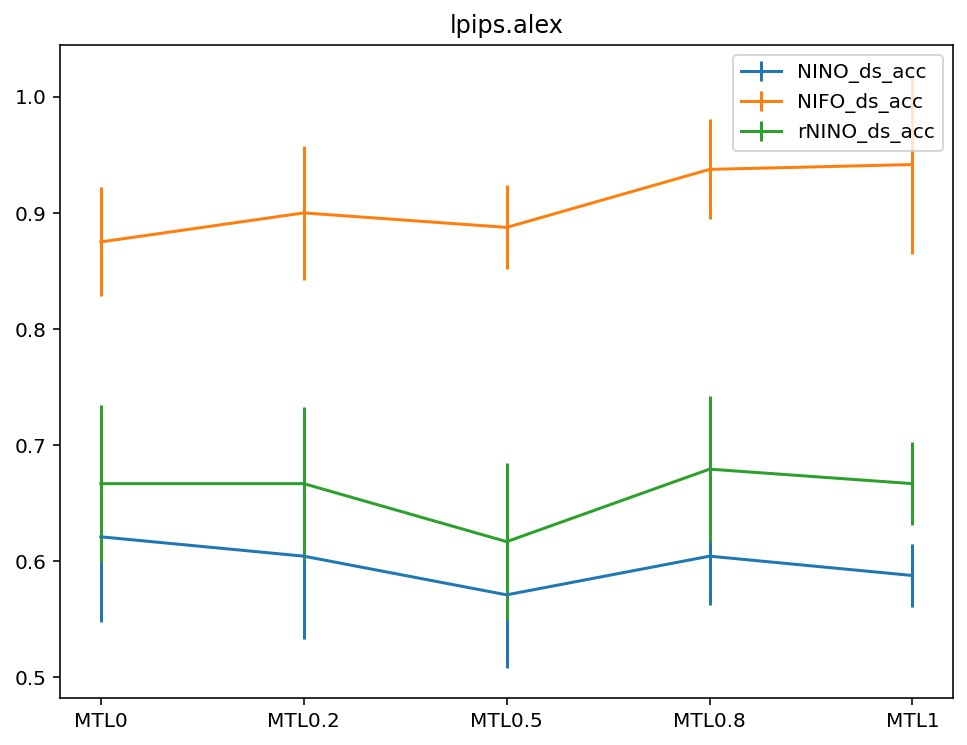

In [182]:
def get_df_plot(df_mean, df_sems, agent, columns, errorbar=True):
    if agent is not None:
        df_mean = df_mean[df_mean['agent'] == agent]
        df_sems = df_sems[df_sems['agent'] == agent]
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    for i, c in enumerate(columns):
        if errorbar:
            ax.errorbar(x=df_mean["model"], y=df_mean[ds_columns[i]], yerr=df_sems[ds_columns[i]] / 2)
        else:
            sns.lineplot(ax=ax, x=df_mean["model"], y=df_mean[ds_columns[i]])
    ax.legend(ds_columns)
    ax.set_title(agent)
    return fig, ax
agent = 'lpips.alex'
get_df_plot(df_mean, df_sems, agent, ds_columns)

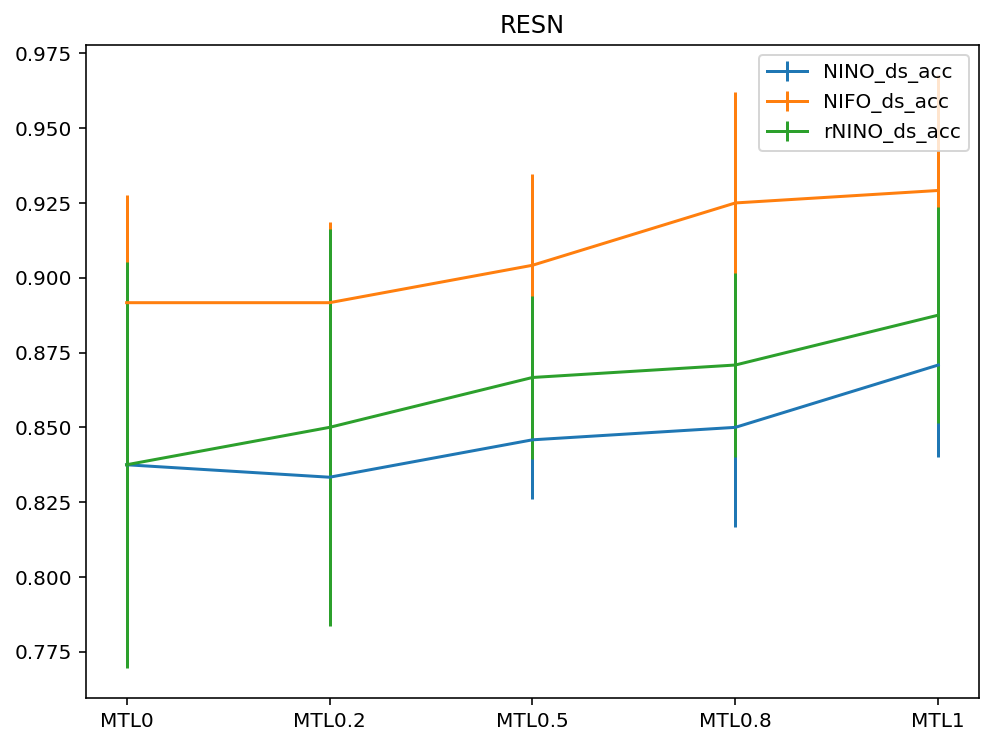

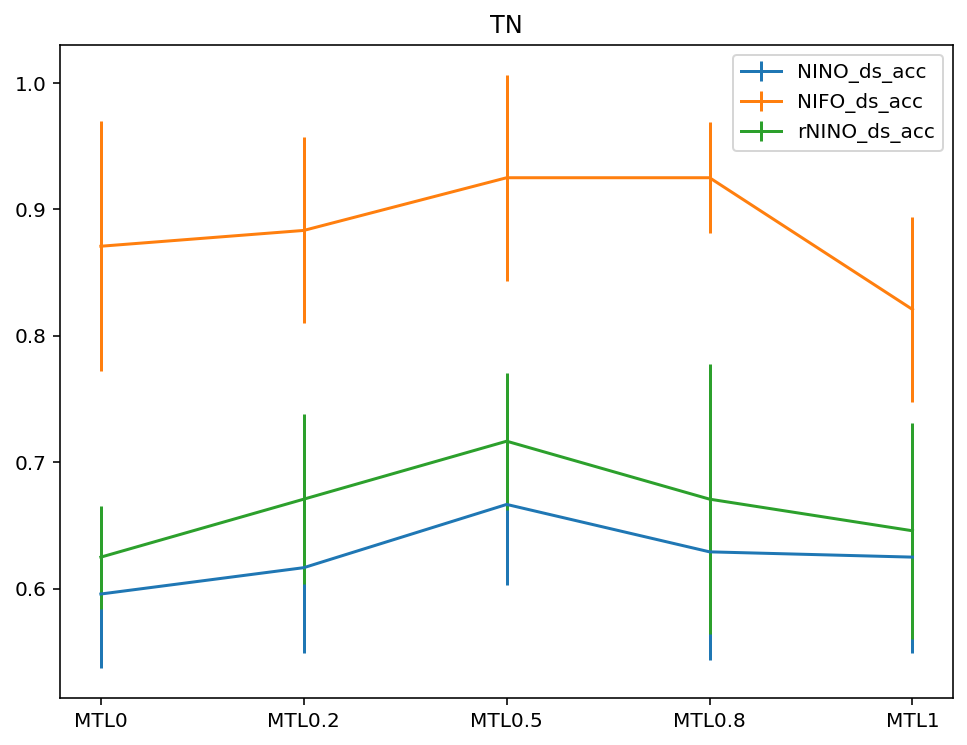

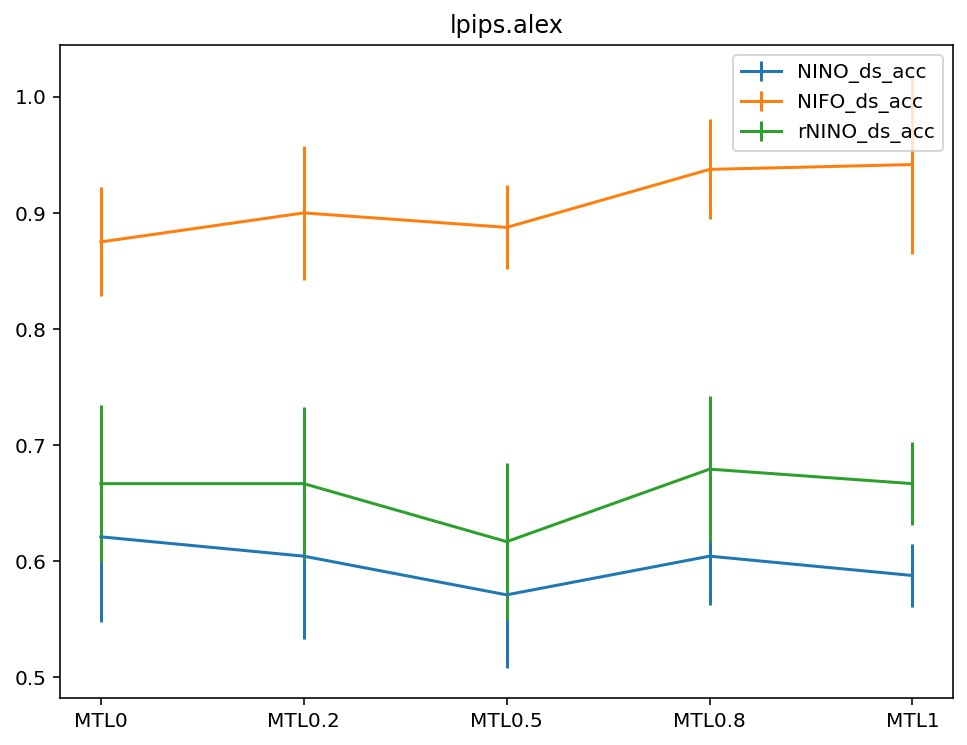

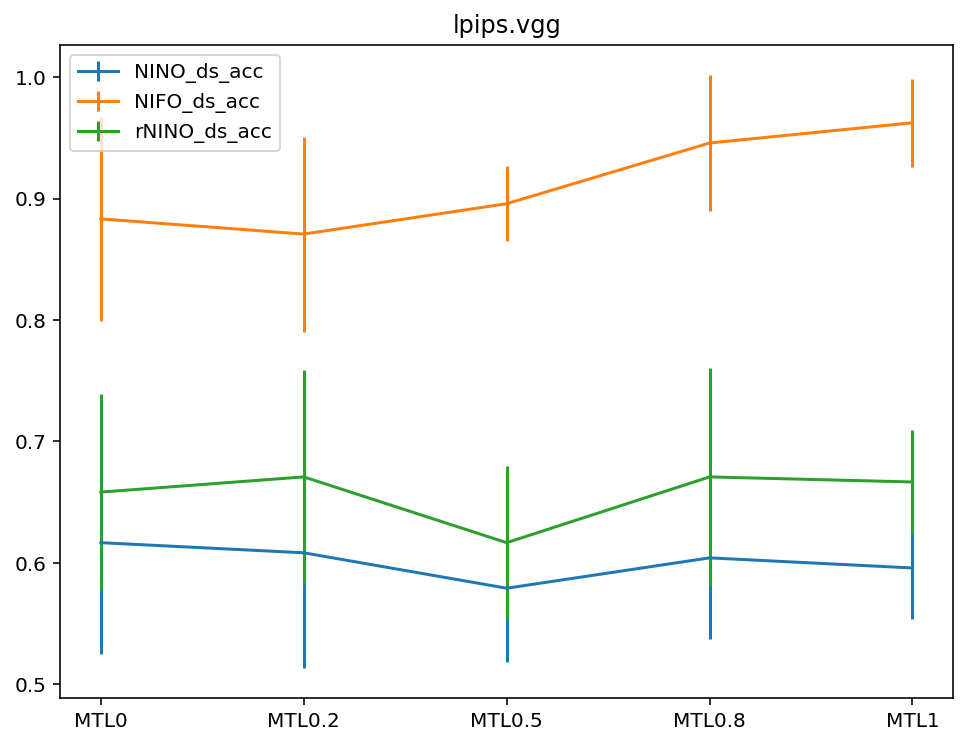

In [183]:
for agent in syns:
    get_df_plot(df_mean, df_sems, agent, ds_columns)

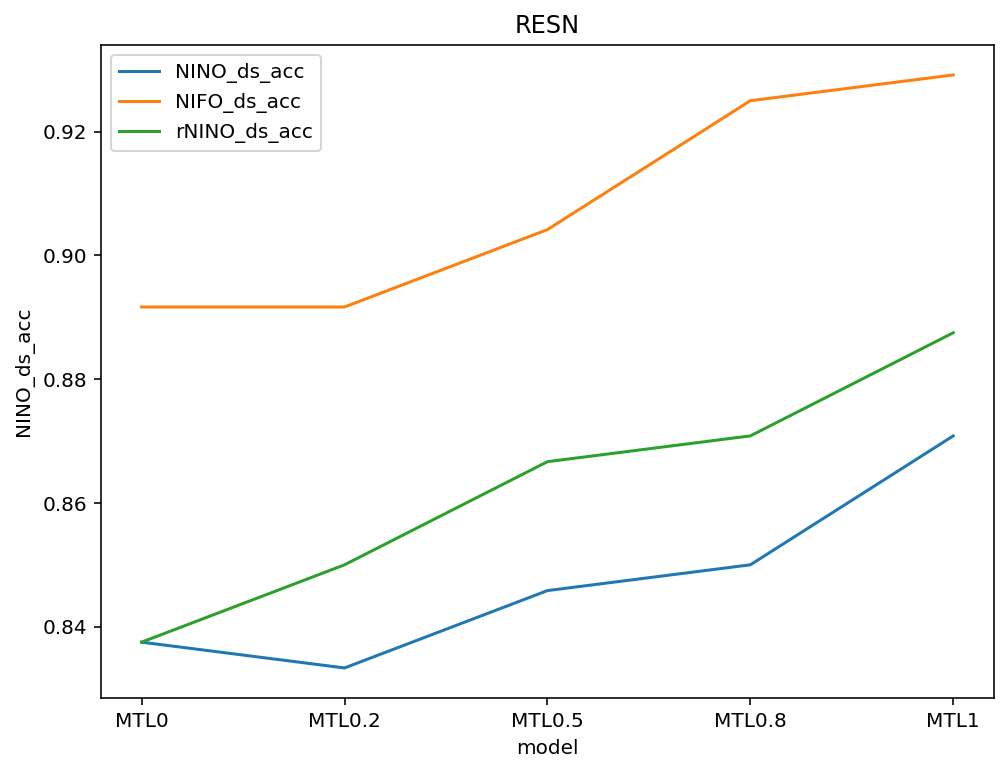

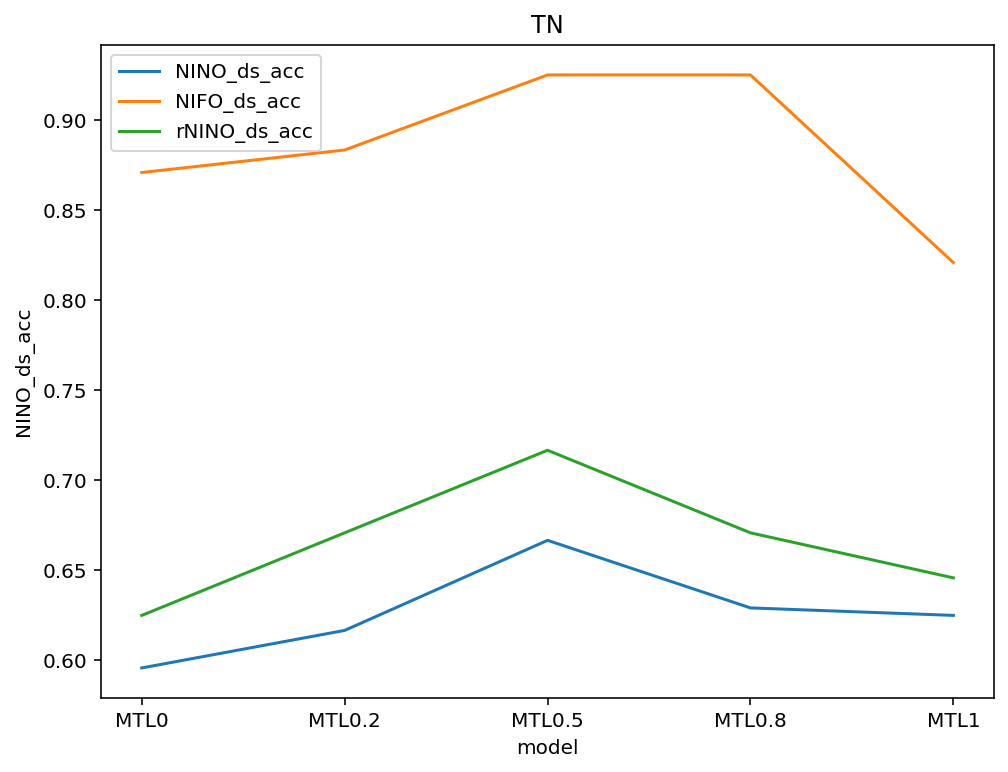

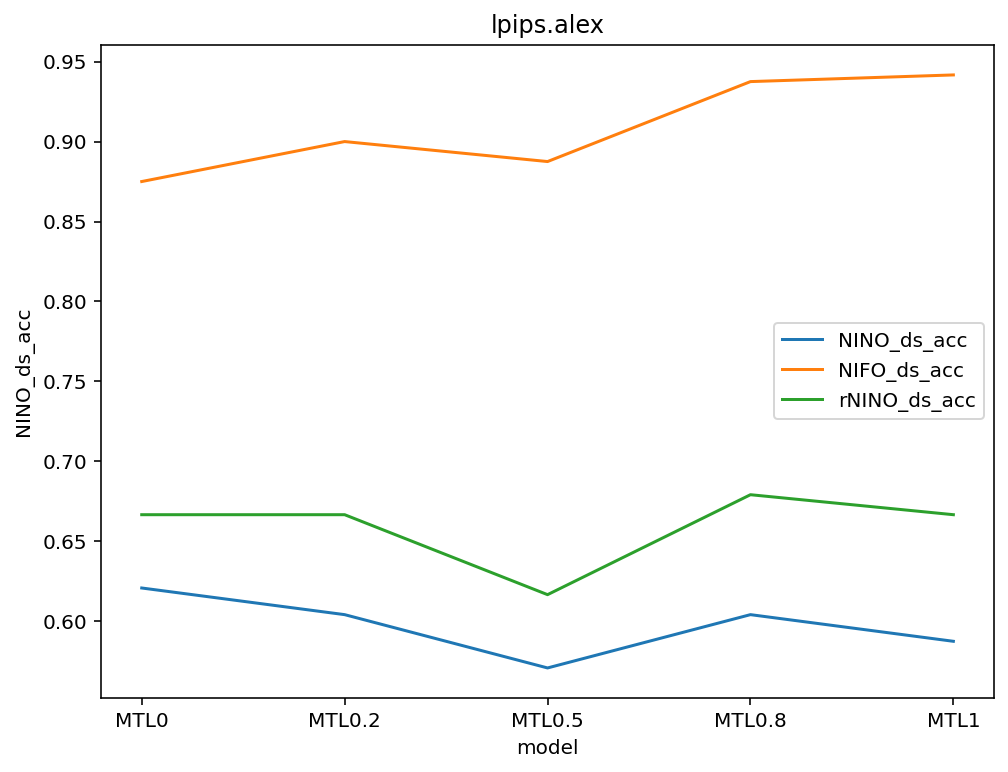

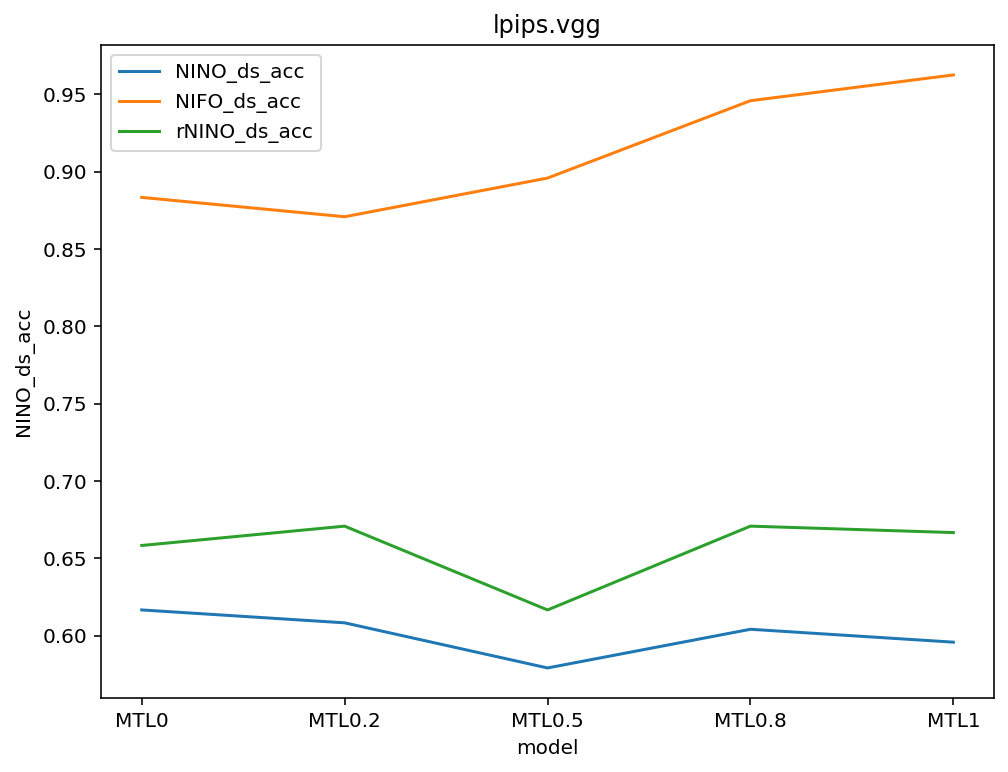

In [184]:
for agent in syns:
    get_df_plot(df_mean, df_sems, agent, ds_columns, errorbar=False)